# Coastal change in African countries

* **Products used:** [DE Africa Coastlines]()



## Background

Coastline change can be summarised in country scale to assess trends of change. 

## Description

Coastlines data is downloaded and used for analysis so its not impacted by limited number of features returned by WFS.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
from shapely.ops import nearest_points

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.coastal import get_coastlines
#from deafrica_tools.plotting import display_map
from datacube.utils.geometry import Geometry

from matplotlib import pyplot as plt
import matplotlib as mpl


/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Load country outlines for plotting

In [2]:
african_countries  = gpd.read_file("../Supplementary_data/MGCI/african_countries.geojson")

In [3]:
african_countries.COUNTRY.values

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo-Brazzaville', 'Cote d`Ivoire',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo',
       'Tunisia', 'Uganda', 'Western Sahara', 'Zambia', 'Zimbabwe'],
      dtype=object)

## Match coastlines to admin boundaries

In [4]:
level = 1

In [5]:
%%time

# load coastlines rate of change and filter to keep only good observations

coastlines = gpd.read_file("~/dev/data/deafricacoastlines_v0.4.0.gpkg", layer="rates_of_change")
coastlines = coastlines[(coastlines.certainty=='good')]
coastlines.reset_index(inplace=True)

CPU times: user 2min 45s, sys: 7.03 s, total: 2min 52s
Wall time: 2min 52s


In [6]:
%%time

# load level 1 admin_boundaries

gadm_africa  = gpd.read_file("~/dev/data/gadm_africa.gpkg")
gadm_level = gadm_africa.dissolve(by=f"GID_{level}")
gadm_level = gadm_level.to_crs(coastlines.crs)
gadm_level.reset_index(inplace=True)

CPU times: user 1min 26s, sys: 255 ms, total: 1min 26s
Wall time: 1min 26s


In [7]:
%%time

# match coastlines to admin region geometries

ind_coast, ind_level =  gadm_level.sindex.nearest(coastlines.geometry, max_distance= 1000, return_all=False, return_distance=False)

CPU times: user 1h 2min 11s, sys: 643 ms, total: 1h 2min 12s
Wall time: 1h 2min 12s


In [1]:
%%time

coastlines.sjoin_nearest(gadm_level, how='left', max_distance=1000, lsuffix='left', rsuffix='right', distance_col=None)
coastlines.to_file(f"~/dev/data/deafricacoastlines_v0.4.0_nearest_gadm_level{level}.gpkg")

NameError: name 'coastlines' is not defined

In [39]:
gadm_level[['n_good', 'n_sig99', 'n_neg1', 'n_neg5', 'rate_time_10th', 'rate_time_50th', 'nsm_10th', 'sce_90th']] = [np.nan]*8

In [40]:
for idx in gadm_level.index:
    #print(gadm_level.loc[idx][f"NAME_{level}"])
    
    good_gdf = coastlines.iloc[ind_coast[ind_level == idx]]
    if len(good_gdf)==0:
        #print("no data over", gadm_level.loc[idx][f"NAME_{level}"])
        continue

    # get stats
    gadm_level.at[idx, 'n_good'] = len(good_gdf)
    sig_gdf = good_gdf[(good_gdf.sig_time<0.01)]
    gadm_level.at[idx, 'n_sig99'] = len(sig_gdf)
    gadm_level.at[idx, 'n_neg1'] = (sig_gdf.rate_time<-1).sum()
    gadm_level.at[idx, 'n_neg5'] = (sig_gdf.rate_time<-5).sum()
    gadm_level.at[idx, 'rate_time_10th'] = sig_gdf.rate_time.quantile(0.1)
    gadm_level.at[idx, 'rate_time_50th'] = sig_gdf.rate_time.quantile(0.5)
    gadm_level.at[idx, 'nsm_10th'] = sig_gdf.nsm.quantile(0.1)
    gadm_level.at[idx, 'sce_90th'] = sig_gdf.sce.quantile(0.9)
    
gadm_level['perc_neg1']=gadm_level['n_neg1']*100/gadm_level['n_good']
gadm_level['perc_neg5']=gadm_level['n_neg5']*100/gadm_level['n_good']
gadm_level['km_neg1']=gadm_level['n_neg1']*30/1000
gadm_level['km_neg5']=gadm_level['n_neg5']*30/1000

In [41]:
gadm_level = gadm_level[gadm_level.n_good>0]
gadm_level.to_file(f"~/dev/data/coastlineschange_gadm_level{level}.gpkg")

In [42]:
gid_1_coastalchange  = gpd.read_file(f"~/dev/data/coastlineschange_gadm_level{level}.gpkg")
gid_1_coastalchange = gid_1_coastalchange.fillna(0)
gid_1_coastalchange = gid_1_coastalchange.to_crs(african_countries.crs)

0.0 80.92909535452323
0 55


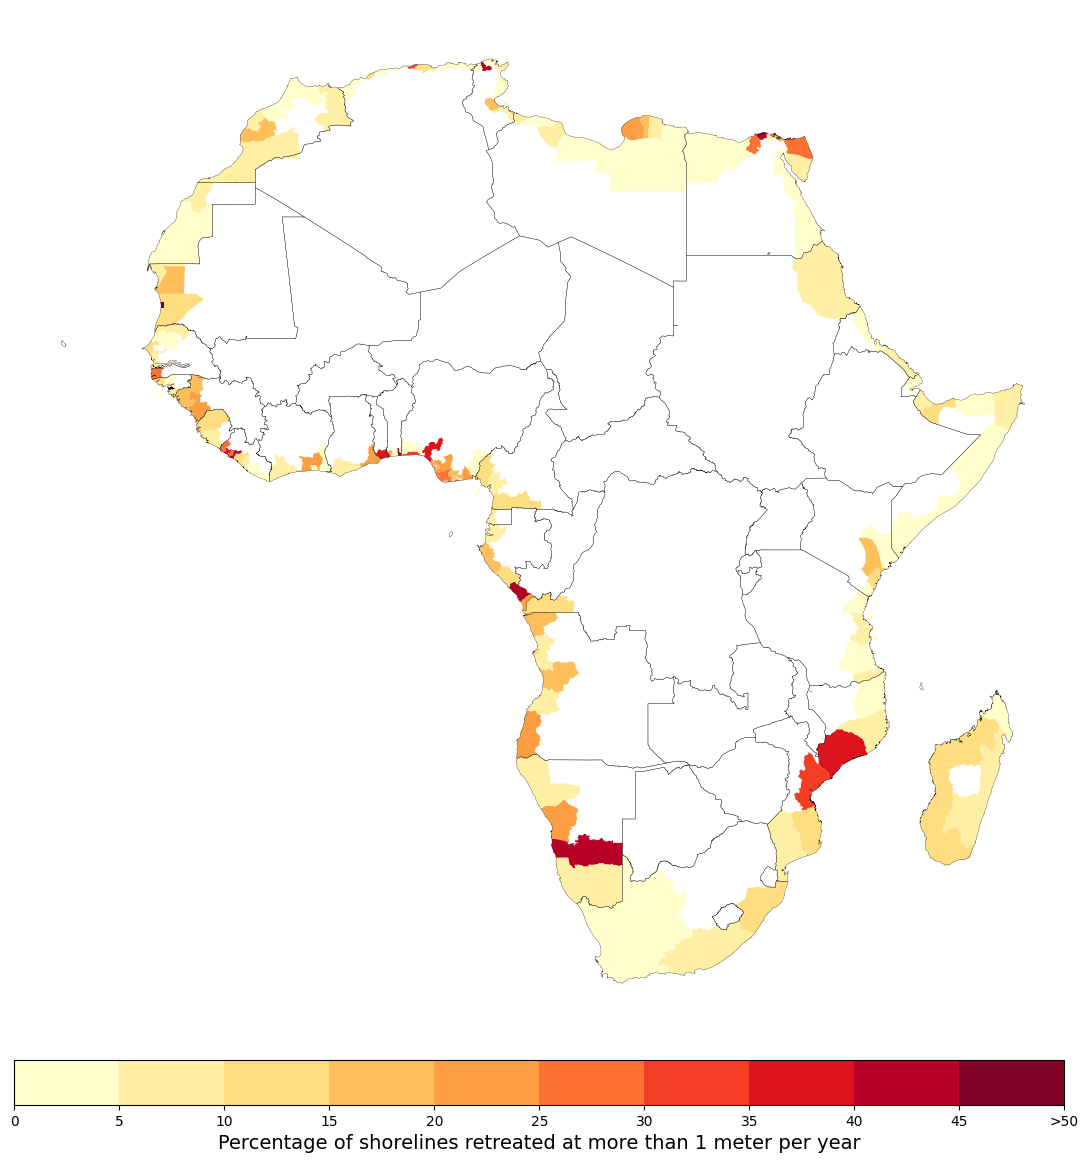

In [43]:
param = 'perc_neg1'
title = 'Percentage of shorelines retreated at more than 1 meter per year'

print(gid_1_coastalchange[param].min(), gid_1_coastalchange[param].max())

steps = 5 #np.ceil((gid_1_coastalchange[param].max()/5)/10)*10
vmin, vmax = 0, 55 #np.ceil(gid_1_coastalchange[param].max()/steps)*steps+steps
print(vmin, vmax)

# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(15,15))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.YlOrRd
bounds = list(np.arange(vmin,vmax,steps))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks(bounds)
ticklabels= list('{:.0f}'.format(i) for i in bounds)
ticklabels[-1]=f">{ticklabels[-1]}"
cbar.set_ticklabels(ticklabels)
cbar.set_label(title, fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gid_1_coastalchange.plot(param, ax=ax, cmap=cmap, norm=norm);
#gid_1_coastalchange.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
#gid_0_coastalchange.simplify(0.05).geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
african_countries.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");


fig.savefig(f"GID_{level}_{param}.png", bbox_inches='tight')

0.0 285.15
0 330.0


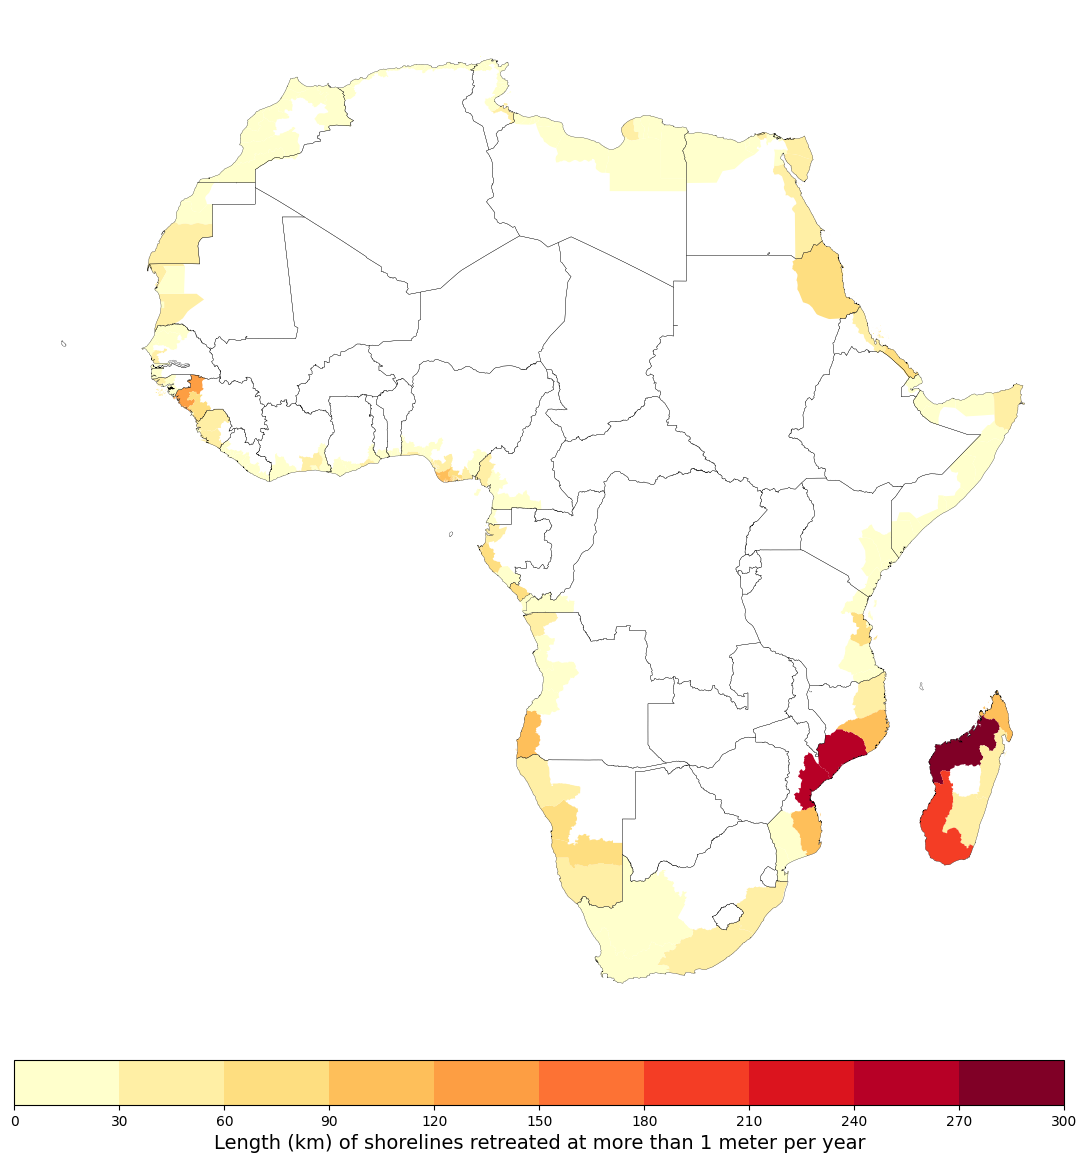

In [44]:
param = 'km_neg1'
title = 'Length (km) of shorelines retreated at more than 1 meter per year'

print(gid_1_coastalchange[param].min(), gid_1_coastalchange[param].max())

steps = np.ceil((gid_1_coastalchange[param].max()/10)/10)*10
vmin, vmax = 0, np.ceil(gid_1_coastalchange[param].max()/steps)*steps+steps
print(vmin, vmax)

# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(15,15))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.YlOrRd
bounds = list(np.arange(vmin,vmax,steps))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks([i for i in np.arange(vmin,vmax,steps)])
cbar.set_ticklabels(list('{:.0f}'.format(i) for i in (list(np.arange(vmin, vmax, steps)))))
cbar.set_label(title, fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gid_1_coastalchange.plot(param, ax=ax, cmap=cmap, norm=norm);
#gid_1_coastalchange.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
#gid_0_coastalchange.simplify(0.05).geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
african_countries.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");


fig.savefig(f"GID_{level}_{param}.png", bbox_inches='tight')